In [3]:
import numpy as np
%load_ext autoreload
%autoreload 2
np.set_printoptions(precision=4,
                    threshold=10000,
                    linewidth=100)
float_formatter = lambda x: "%.6f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from textunit import TextUnit
from twitter_dm.utility.general_utils import read_grouped_by_newline_file
from constraints import get_id_and_value_map
import io
import sys
import codecs
from constraints import IDENTITY_PREFIX, SENTWORD_PREFIX
from collections import defaultdict

sys.stdout = codecs.getwriter('utf-8')(sys.stdout)

# read in sentiment word values
sent_dict = {}
for x in io.open("../data/all_epa_terms.txt"):
    x_spl = x.split("\t")
    sent_dict[x_spl[0]] = [float(z) for z in x_spl[1:]]

# make up identity values
IDENTITY_LIST_FN = "../data/identities_for_study.txt"
identity_dict = {x.strip().lower() : sent_dict.get(x.strip().lower(), [0.,0.,0.])
                 for x in open(IDENTITY_LIST_FN)}


identity_to_id, identity_values = get_id_and_value_map(identity_dict, IDENTITY_PREFIX)
sent_to_id, sent_values = get_id_and_value_map(sent_dict,SENTWORD_PREFIX)
gram_list = set(identity_to_id.keys())|set(sent_to_id.keys())

In [47]:
import cPickle as pickle
pickle.dump(users_to_tweets, open("u_to_.p","wb"))

In [2]:
import cPickle as pickle
users_to_tweets = pickle.load(open("u_to_t.p","rb"))

NameError: global name 'defaultdict' is not defined

In [3]:
from user import User
users = []

for u, tweets in users_to_tweets.items():
    users.append(User(u, tweets))

In [4]:
# association matrix data
from gensim import corpora, models, similarities
from gensim.matutils import corpus2dense

texts = [u.identities for u in users]
dictionary = corpora.Dictionary(texts) 
#dictionary.filter_extremes(no_below=100)
print dictionary
corpus = [dictionary.doc2bow(u.identities) for u in users]

corp_mat = corpus2dense(corpus,len(dictionary))

print 'SHAPE: ', corp_mat.shape

for i,u in enumerate(users):
    u.identities_vector = corp_mat[:,i]

Dictionary(1264 unique tokens: [u'i_1485', u'i_1253', u'i_1528', u'i_1529', u'i_1481']...)
SHAPE:  (1264, 100)


In [2]:
# A simple test data set
import numpy as np
from user import User
import numpy as np
from stat_util import softmax
from textunit import FakeTextUnit
N_USERS = 1000
N_IDENTITIES = 100
N_ITERATIONS = 4
N_DOCS_PER_USER = 200

# fake association model data
fake_data_mu = np.array([i % 5 for i in *N_IDENTITIES])
fake_data_mu[-1] = 2
fake_data_sigma = np.identity(np.shape(fake_data_mu)[0])
fake_data_sigma[0,1] = .8
fake_data_sigma[1,0] = .8
fake_etas = np.zeros((N_USERS, N_IDENTITIES))
# generate fake etas
for i in range(N_IDENTITIES):
    fake_etas[:,i] = np.random.normal(fake_data_mu[i], fake_data_sigma[i,i], (N_USERS))
fake_data_sigma[0,1] = .8
fake_data_sigma[1,0] = .8
fake_etas[:,:2] = np.random.multivariate_normal(fake_data_mu[:2], fake_data_sigma[:2,:2], N_USERS)


# fake sentiment model data
identity_values = {i:i%5 for i in range(N_IDENTITIES)}
sentiment_values = {}
identity_mus = identity_values.values()

# Draw user's sentiment views from mu, sigma
fake_users = np.zeros((N_USERS, N_IDENTITIES))
for i in range(N_IDENTITIES):
    fake_users[:,i] = np.random.normal(identity_mus[i], 1, N_USERS)

users = [User(u,[]) for u in range(N_USERS)]
n_docs_per_user = np.random.normal(N_DOCS_PER_USER, 4, N_USERS)

print 'getting users'
for user_it in range(N_USERS):
    theta = softmax(fake_etas[user_it])
    #print 'User: ', u
    n_docs = n_docs_per_user[user_it]
    users[user_it].identities_vector = np.zeros(N_IDENTITIES)

    # for each document
    for doc in range(int(n_docs)):
        #pick an identity
        identities = np.random.multinomial(1, theta)
        tweet = FakeTextUnit()
        for identity_it in range(N_IDENTITIES):
            if identities[identity_it] > 0:
                # if identity is active, add constraint
                sd_val = np.random.uniform(0,4)
                tweet.add_fake_constraint(identity_it,fake_users[user_it,identity_it])
                break
        # add text unit to user
        users[user_it].add_tweet(tweet)
        users[user_it].identities_vector += identities

getting users


In [3]:
import sentiment_model
import association_model

print 'init for association model'
assoc_model = association_model.AssociationModel(users,N_IDENTITIES)
print 'init for sentiment model'
sent_model = sentiment_model.SentimentModel(users, identity_values,nu=1000, w_mult=10)

for i in range(10):
    print 'iter: ', i
    print '\t updating association'
    assoc_model.iterate()
    print '\t updating sentiment'
    sent_model.iterate(sentiment_values)

init for association model
init for sentiment model
iter:  0
	 updating association
	 updating sentiment
iter:  1
	 updating association
	 updating sentiment
iter:  2
	 updating association
	 updating sentiment
iter:  3
	 updating association
	 updating sentiment
iter:  4
	 updating association
	 updating sentiment
iter:  5
	 updating association
	 updating sentiment
iter:  6
	 updating association
	 updating sentiment
iter:  7
	 updating association
	 updating sentiment
iter:  8
	 updating association
	 updating sentiment
iter:  9
	 updating association
	 updating sentiment


In [ ]:
print 'SENT MU: '
for i in range(N_IDENTITIES):
    print i, sent_model.mu[i]

/Users/kennyjoseph/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/kennyjoseph/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


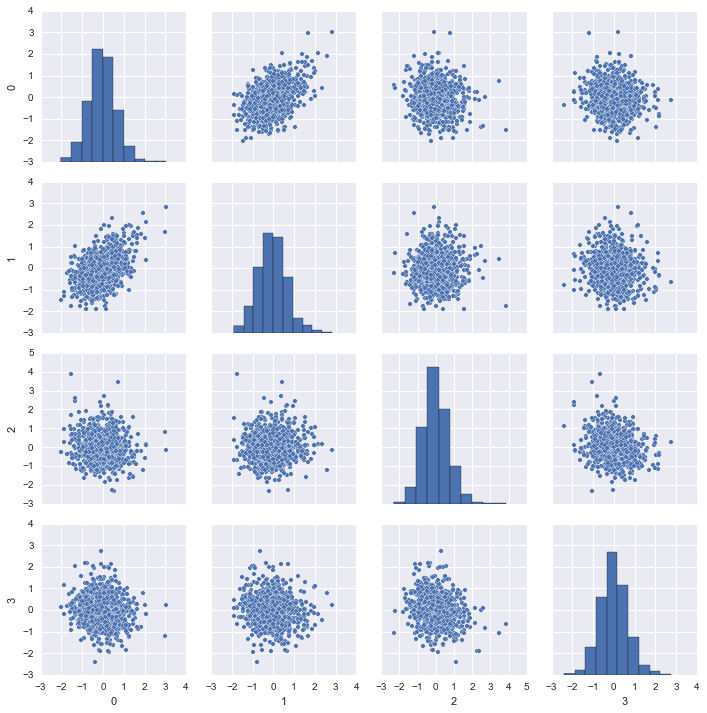

In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import linalg
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphLassoCV, ledoit_wolf

sns.set()
sns.pairplot(pd.DataFrame(assoc_model.eta[:,:4]))

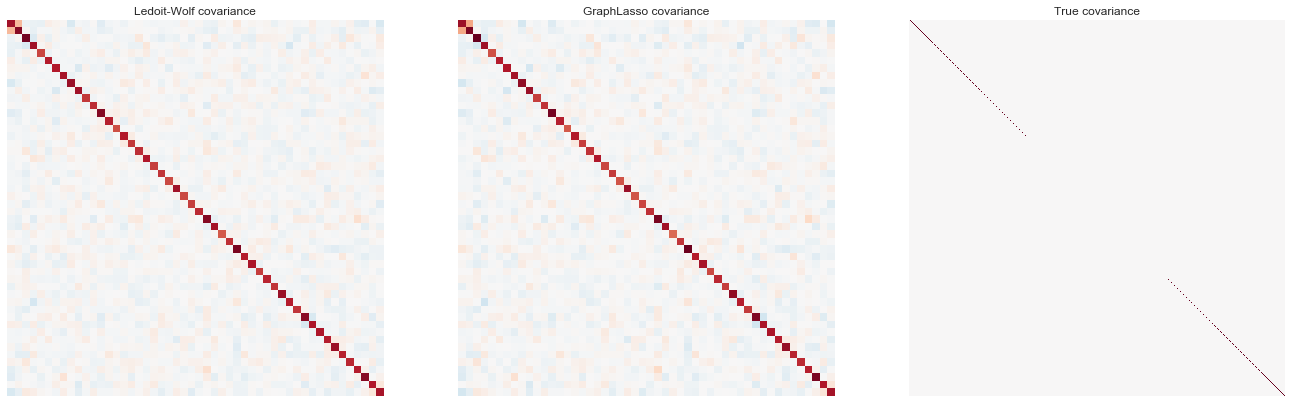

In [13]:
d = assoc_model.eta[:,:50]
model = GraphLassoCV()
model.fit(d)
cov_ = model.covariance_
prec_ = model.precision_

lw_cov_, _ = ledoit_wolf(d)
lw_prec_ = linalg.inv(lw_cov_)

plt.figure(figsize=(25, 25))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [ ('Ledoit-Wolf', lw_cov_),('GraphLasso', cov_), ('True', fake_data_sigma)]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(this_cov, interpolation='nearest', vmin=-vmax, vmax=vmax,
               cmap=plt.cm.RdBu_r)
    plt.xticks(())
    plt.yticks(())
    plt.title('%s covariance' % name)